# Spatial join

*Spatial joins* are operations that combine data from two or more spatial data
sets based on their geometric relationship. In the previous sections, we got to
know two specific cases of spatial joins: [Point-in-polygon
queries](point-in-polygon-queries) and [intersects-queries](intersect). However,
there is more to using the geometric relationship between features and between
entire layers.

Spatial join operations require two input parameters: the *predicament*, i.e., the
geometric condition that needs to be met between two geometries, and the
*join-type*: whether only rows with matching geometries are kept, or all of one
input table’s rows, or all records. 

*Geopandas* (using `shapely` to implement geometric relationships) [supports a
standard set of geometric
predicates](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins),
that is similar to most GIS analysis tools and applications:

- intersects
- contains
- within
- touches
- crosses
- overlaps

Geometric predicaments are expressed as verbs, so they have an intuitive
meaning. See the [shapely user
manual](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)
for a detailed description of each geometric predicate.


:::{admonition} Binary geometric predicates
:class: hint

Shapely supports more *binary geometric predicates* than geopandas implements
for spatial joins. What are they? Can they be expressed by combining the
implemented ones?
:::


In terms of the *join-type*, geopandas implements three different options:

- *left*: keep all records of the *left* data frame, fill with empty values if
  no match, keep *left* geometry column
- *right*: keep all records of the *left* data frame, fill with empty values if
  no match, keep *right* geometry column
- *inner*: keep only records of matching records, keep *left* geometry column


:::{tip}
The [PyGIS
book](https://pygis.io/docs/e_spatial_joins.html) has a great overview of
spatial predicaments and join-types with explanatory drawings.
:::


---


## Load input data

As a practical example, let’s find the population density at each of the
addresses from [earlier in this lesson](geocoding-in-geopandas), by combining
the data set with data from a population grid.

The population grid data is available from [HSY, the Helsinki Region
Environmental
Services](https://www.hsy.fi/en/environmental-information/open-data/), for
instance via their WFS endpoint.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
#import os
#os.environ['USE_PYGEOS'] = '0'
import geopandas
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

addresses = geopandas.read_file(DATA_DIRECTORY / "addresses.gpkg")

population_grid = geopandas.read_file(
    (
        "https://kartta.hsy.fi/geoserver/wfs"
        "?service=wfs"
        "&version=2.0.0"
        "&request=GetFeature"
        "&typeName=asuminen_ja_maankaytto:Vaestotietoruudukko_2020"
        "&srsName=EPSG:3879"
    ),
)
population_grid.crs = "EPSG:3879"  # for WFS data, the CRS needs to be specified manually

:::{admonition} Concatenating long strings
:class: note

In the WFS address above, we split a long string across multiple lines. Strings
between parentheses are automatically concatenated (joint together), even
without any operator (e.g., `+`).

For the sake of clarity, the example has an additional set of parentheses, but
already the parentheses of the method call would suffice.
:::


---

In [3]:
population_grid.head()

,gml_id,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80,geometry
0,Vaestotietoruudukko_2020.1,703,5,51,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
1,Vaestotietoruudukko_2020.2,710,8,44,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
2,Vaestotietoruudukko_2020.3,711,5,90,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
3,Vaestotietoruudukko_2020.4,715,13,34,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6682998.998, 25472499.9..."
4,Vaestotietoruudukko_2020.5,848,5,53,99,99,99,99,99,99,99,99,99,"POLYGON ((25472749.993 6690249.003, 25472749.9..."


The population grid has many columns, and all of its column names are in
Finnish. Let’s drop (delete) all of the columns except the population total,
and rename the remaining to English:

In [4]:
population_grid = population_grid[["asukkaita", "geometry"]]
population_grid = population_grid.rename(columns={"asukkaita": "population"})

Finally, calculate the population density by dividing the number of inhabitants
of each grid cell by its area in km²:

In [5]:
population_grid["population_density"] = (
    population_grid["population"]
    / (population_grid.area / 1_000_000)
)
population_grid.head()

,population,geometry,population_density
0,5,"POLYGON ((25472499.995 6685998.998, 25472499.9...",80.001048
1,8,"POLYGON ((25472499.995 6684249.004, 25472499.9...",128.001677
2,5,"POLYGON ((25472499.995 6683999.005, 25472499.9...",80.001048
3,13,"POLYGON ((25472499.995 6682998.998, 25472499.9...",208.002724
4,5,"POLYGON ((25472749.993 6690249.003, 25472749.9...",79.998352


:::{admonition} Coding style: big numbers, operators in multi-line expressions
:class: tip

If you need to use very large numbers, such as, in the above example, the *1
million* to convert m² to km², you can use underscore characters (`_`) as
thousands separators. The Python interpreter will treat a sequence of numbers
interleaved with underscores as a regular numeric value.
[You can use the same syntax to group
numbers](https://peps.python.org/pep-0515/) by a different logic, for instance,
to group hexadecimal or binary values into groups of four.

In case an expression, such as, e.g., a mathematical formula, spreads across
multiple lines, it is considered good coding style to place an operator at the
beginning of a new line, rather than let it trail in the previous line. This is
considered more readable, as explained in the [PEP-8 styling
guidelines](https://peps.python.org/pep-0008/#should-a-line-break-before-or-after-a-binary-operator)
:::


---


## Join input layers


Now we are ready to perform the spatial join between the two layers.
Remember: the aim is to find the population density around each of the address
points. We want to attach population density information from the
`population_grid` polygon layer to the `addresses` point layer, depending on
whether the **point is within the polygon**. During this operation, we want to
**retain the geometries of the point layer**.

Before we can go ahead with the join operation, we have to make sure the two
layers are in the same cartographic reference system:

In [6]:
assert addresses.crs == population_grid.crs, "CRS are not identical"

AssertionError: CRS are not identical

They do not share the same CRS, let’s reproject one of them:

In [7]:
population_grid.to_crs(addresses.crs, inplace=True)

Now we are ready to carry out the actual spatial join using the
[`geopandas.GeoDataFrame.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html)
method. Remember, we want to use a *within* geometric predicate and retain the
point layer’s geometries (in the example below the *left* data frame).

In [8]:
addresses_with_population_data = addresses.sjoin(
    population_grid,
    how="left",
    predicate="within"
)
addresses_with_population_data.head()

,address,geometry,index_right,population,population_density
0,"Ruoholahti, 14, Itämerenkatu, Salmisaari, Ruoh...",POINT (24.91556 60.16320),3247.0,492.0,7872.103107
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",POINT (24.93166 60.16905),3362.0,182.0,2912.038141
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",POINT (24.94179 60.16989),3485.0,45.0,720.009431
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",POINT (24.97846 60.19032),NaN,NaN,NaN
4,"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",POINT (24.92169 60.15667),3293.0,1410.0,22559.535398


That looks great! We now have an address data set with population density
information attached to it. 


---


As a final task, let’s look at how to plot data using a *graduated*
cartographic visualisation scheme. 

The `geopandas.GeoDataFrame.plot()` method can vary the map colours depending on a column’s values by passing its name as a named argument `column`. On top of that, the method accepts many arguments to influence the style of the map. Among them are `scheme` and `cmap` that define the [categorisation scheme](https://geopandas.org/en/stable/gallery/choropleths.html), and the [colour map](https://matplotlib.org/stable/tutorials/colors/colormaps.html) used. Many more arguments are passed through to `matplotlib`, such as `markersize` to set the size of point symbols, and `facecolor` to set the colour of polygon areas. To draw a legend, set `legend` to `True`, to set the size of the figure, pass a tuple (with values in inch) as `figsize`.

Text(0.5, 1.0, 'Population density around address points')

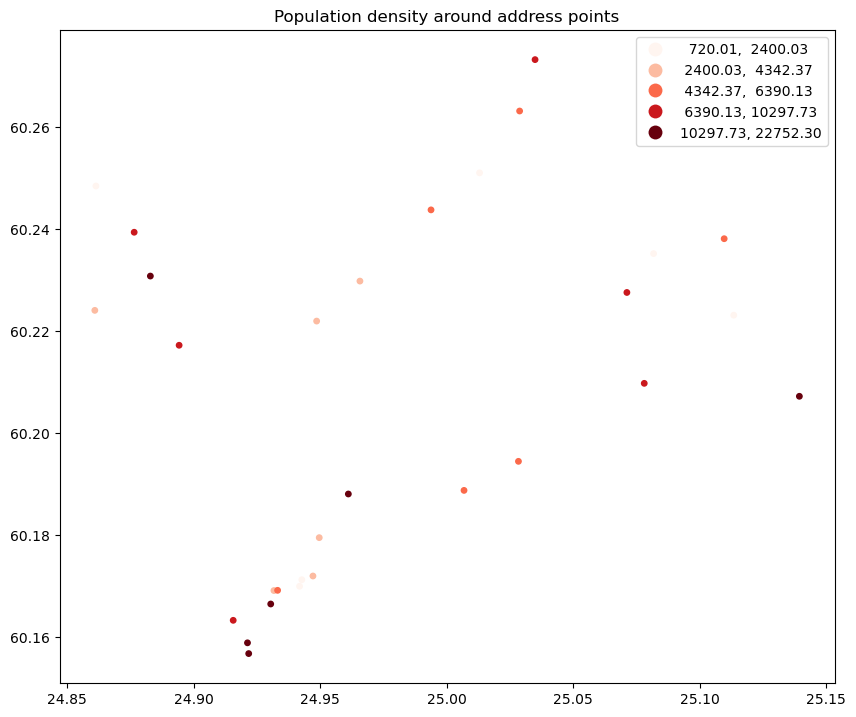

In [9]:
ax = addresses_with_population_data.plot(
    figsize=(10, 10),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    markersize=15,
    legend=True
)
ax.set_title("Population density around address points")

We can apply the same arguments to plot a population density map using the
entire `population_grid` data set:

Text(0.5, 1.0, 'Population density in the Helsinki metropolitan area')

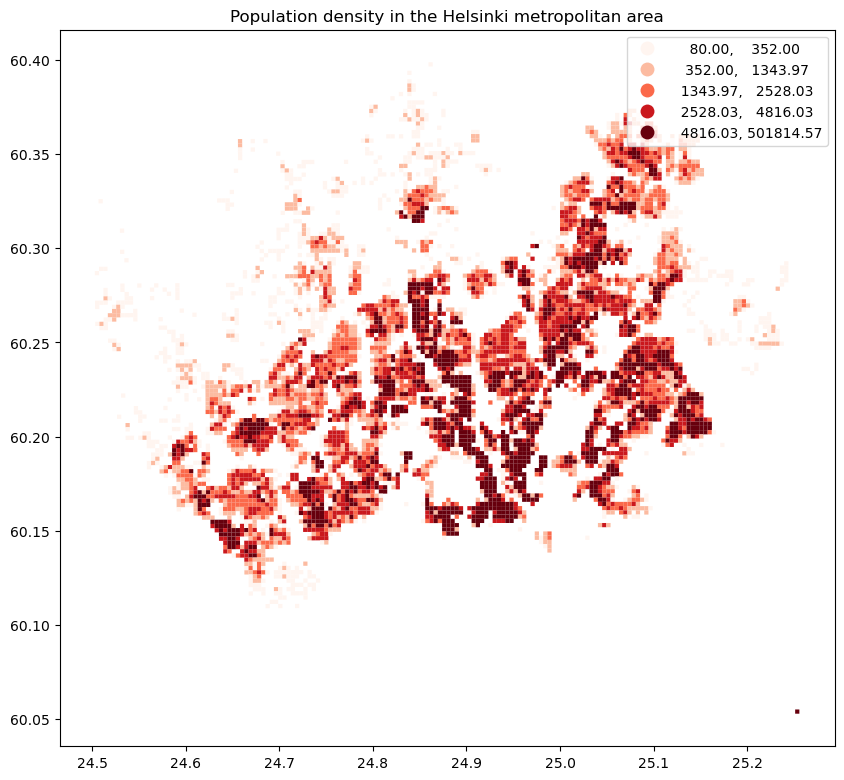

In [10]:
ax = population_grid.plot(
    figsize=(10, 10),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    legend=True
)
ax.set_title("Population density in the Helsinki metropolitan area")

Finally, remember to save the output data frame to a file. We can append it to
the existing *GeoPackage* by specifying a new layer name:

In [11]:
addresses_with_population_data.to_file(
    DATA_DIRECTORY / "addresses.gpkg",
    layer="addresses_with_population_data"
)